# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [77]:
import tensorflow as tf
import numpy as np
import tensorflow.keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Convolution2D
import pandas as pd
import cv2
import os
from PIL import Image
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import Model

### Change directory

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/ACV Lab Questions and Data Set/')

### Load the training data from train.csv file

In [80]:
df_Image = pd.read_csv("train_labels.csv")

### Print the shape of the train dataset

In [81]:
df_Image.shape

(173, 8)

In [82]:
df_Image.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [83]:
df_Image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  173 non-null    object
 1   width     173 non-null    int64 
 2   height    173 non-null    int64 
 3   class     173 non-null    object
 4   xmin      173 non-null    int64 
 5   ymin      173 non-null    int64 
 6   xmax      173 non-null    int64 
 7   ymax      173 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 10.9+ KB


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [84]:
IMAGE_SIZE = 128
IMAGE_PATH_BASE_FOLDER = "/content/gdrive/My Drive/Colab Notebooks/ACV Lab Questions and Data Set/images_racoon/images/"

In [85]:
ls IMAGE_PATH_BASE_FOLDER

ls: cannot access 'IMAGE_PATH_BASE_FOLDER': No such file or directory


### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [86]:
import csv
with open("train_labels.csv", 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):            
      for i, r in enumerate(row):
        if((i!= 0) & (i!=3)):
          row[i] = int(r)          
      image_name, image_width, image_height, _, x0, y0, x1, y1 = row  
      #print(image_name)
      coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
      coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
      coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
      coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
      paths.append(IMAGE_PATH_BASE_FOLDER+image_name)
      #print(paths)

In [87]:
paths[0]

'/content/gdrive/My Drive/Colab Notebooks/ACV Lab Questions and Data Set/images_racoon/images/raccoon-17.jpg'

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [88]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [89]:
batch_images[0]

array([[[-0.38823527, -0.20784312, -0.3098039 ],
        [-0.8901961 , -0.7647059 , -0.84313726],
        [-0.9137255 , -0.8509804 , -0.8980392 ],
        ...,
        [ 0.04313731,  0.5137255 ,  0.05882359],
        [ 0.04313731,  0.4666667 ,  0.18431377],
        [ 0.26274514,  0.654902  ,  0.38823533]],

       [[-0.4352941 , -0.27843136, -0.36470586],
        [-0.9529412 , -0.8666667 , -0.92941177],
        [-0.8509804 , -0.79607844, -0.827451  ],
        ...,
        [-0.23921567,  0.21568632, -0.23921567],
        [-0.0745098 ,  0.33333337,  0.00392163],
        [ 0.09019613,  0.4431373 ,  0.20784318]],

       [[-0.7019608 , -0.5764706 , -0.64705884],
        [-0.85882354, -0.77254903, -0.8117647 ],
        [-0.81960785, -0.78039217, -0.78039217],
        ...,
        [-0.2862745 ,  0.1686275 , -0.5058824 ],
        [-0.1607843 ,  0.26274514, -0.31764704],
        [-0.08235294,  0.254902  , -0.02745098]],

       ...,

       [[-0.04313725,  0.27843142, -0.25490195],
        [-0

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [90]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Convolution2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [91]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [96]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [97]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) 
model.fit(batch_images,coords,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
6/6 [==============================] - 2s 325ms/step - loss: 2083.2104 - IoU: 0.1538
Epoch 2/30
6/6 [==============================] - 2s 327ms/step - loss: 558.7198 - IoU: 0.5121
Epoch 3/30
6/6 [==============================] - 2s 325ms/step - loss: 641.7020 - IoU: 0.5336
Epoch 4/30
6/6 [==============================] - 2s 338ms/step - loss: 428.1799 - IoU: 0.5747
Epoch 5/30
6/6 [==============================] - 2s 323ms/step - loss: 266.1826 - IoU: 0.5708
Epoch 6/30
6/6 [==============================] - 2s 323ms/step - loss: 224.1685 - IoU: 0.6107
Epoch 7/30
6/6 [==============================] - 2s 331ms/step - loss: 170.5968 - IoU: 0.6808
Epoch 8/30
6/6 [==============================] - 2s 323ms/step - loss: 140.2104 - IoU: 0.7185
Epoch 9/30
6/6 [==============================] - 2s 323ms/step - loss: 117.6373 - IoU: 0.7484
Epoch 10/30
6/6 [==============================] - 2s 329ms/step - loss: 102.0320 - IoU: 0.7501
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [102]:
import cv2
filename = 'Test.jpg'
print(filename)
unscaled = cv2.imread(filename)

Test.jpg


### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [103]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [104]:
region = model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

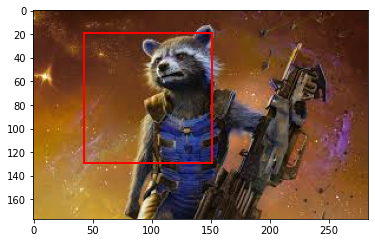

In [105]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()